# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
# Запустите эту ячейку если работаете в Colab
!git clone https://github.com/TheAceHome/ML.git
%cd ML/data
! wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat
%cd ../Assignment3

Cloning into 'ML'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 223 (delta 86), reused 193 (delta 71), pack-reused 0
Receiving objects: 100% (223/223), 820.82 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/ML/data
--2021-03-08 11:14:52--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  46.0MB/s    in 5.5s    

2021-03-08 11:14:58 (31.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-08 11:14:58--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP reques

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [8]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("../data", max_train=10000, max_test=1000)    

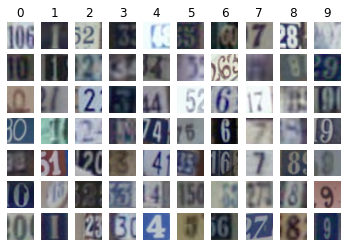

In [9]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = [str(i) for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [11]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

1.6159940625632276 1.6159940625648515
0.0 0.0
2.7625252407895857 2.7625252407403873
0.0 0.0
-0.5060347044691067 -0.506034704450542
-0.9430251923423104 -0.9430251923348009
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [16]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-7.808594023914493e-05 -7.808594023120397e-05
0.0004920660963065252 0.0004920660962894063
0.0002765840805602204 0.00027658408050836025
-0.0003876483217848393 -0.00038764832177573533
-0.002128405287756372 -0.002128405287779578
0.001977236731438227 0.0019772367314610517
Gradient check passed!
2.562951529601496 2.5629515296014294
-3.242361017969395 -3.2423610179695137
2.35291876027037 2.3529187602703767
3.515616225283665 3.5156162252836762
-5.125903059202992 -5.125903059202945
6.48472203593879 6.484722035938854
-4.70583752054074 -4.705837520540666
-7.03123245056733 -7.0312324505673525
1.2040996797660268 1.2040996797660526
-9.894148235348904 -9.894148235349043
1.0226986129337912 1.0226986129336506
7.775010215554946 7.77501021555502
Gradient check passed!
-0.5263699646883453 -0.526369964688354
0.6855988959067897 0.685598895906747
1.0154290746543495 1.015429074654366
1.2240926375413705 1.2240926375413612
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [22]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
-2.8056874958699077e-05 -2.8056845735591193e-05
-1.8046203102959462e-05 -1.8046186767151084e-05
-1.5736393477231584e-05 -1.573638996887894e-05
-2.3537955158366014e-05 -2.3537971571840895e-05
-2.082642553527938e-05 -2.0826451674338383e-05
-1.9190153751260243e-05 -1.9190160571724846e-05
8.890053387650545e-06 8.890044256304463e-06
-2.503334296750829e-05 -2.503333096370852e-05
-2.7395663423351216e-05 -2.739568571996642e-05
-2.8560998487369935e-05 -2.8560975806612984e-05
-1.695381069821587e-05 -1.69538161287619e-05
-1.4527388219572148e-05 -1.4527401503983127e-05
-2.546161402502023e-05 -2.5461588393227427e-05
-1.9162438721820924e-05 -1.9162449405030202e-05
-1.7213973942063774e-05 -1.7213963587892067e-05
4.15508064645796e-06 4.155076283041126e-06
-2.4509891118082216e-05 -2.4509905216518742e-05
-2.6293172800509152e-05 -2.6293189847592654e-05
-2.879280528849982e-05 -2.8792790374154716e-05
-1.0500883229290485e-05 -1.050086684273

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [23]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Выходные данные были обрезаны до нескольких последних строк (5000).
0.005934271281075041 0.005934271296581527
0.00814238600868317 0.008142386009879488
0.02450657013891791 0.02450657015096169
0.0025302595050065184 0.0025302594908183096
0.008159550898371205 0.008159550901609691
0.02368709721294463 0.023687097217006677
-0.015553626920890027 -0.015553626919739825
0.015824110997056665 0.015824110999318464
-0.027896423078483078 -0.02789642306044726
0.0013235626977827373 0.0013235626816765489
-0.004746969564109078 -0.0047469695729773775
-0.014387257835151731 -0.014387257829540088
0.019483243476717323 0.019483243485218793
0.020570238166698184 0.020570238157269216
0.02142935788595376 0.021429357888180785
0.007589039460997866 0.0075890394413136155
-0.024651594887566103 -0.02465159487652357
-0.006587470243095057 -0.006587470258168081
0.020157618074088304 0.02015761808582539
0.01985377016251933 0.01985377016122669
0.0239890915365326 0.023989091557652383
0.006319578389005876 0.00631957837171626
-0.

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [24]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться в некоторых эпохах. Не беспокойтесь пока про validation accuracy.

In [27]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.309821, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292726, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300518, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298788, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291958, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297696, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296733, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294292, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298866, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294089, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299977, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303118, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294964, Train acc

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [28]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.320264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309526, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289420, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296041, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258783, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312859, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.337332, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297394, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266906, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294637, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318550, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260964, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297932, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301268, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315069, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [29]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.334279, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310635, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294840, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295429, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298956, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278106, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306632, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301983, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276044, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304010, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278138, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304250, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257968, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.310420, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308489, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.316512, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [30]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.341631, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.327964, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297732, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.294449, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.266565, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.296226, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.238601, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.251152, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.125685, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.056193, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.340399, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.801095, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.562174, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.013464, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.157311, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.933314, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [31]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.343869, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.311967, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.315280, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294864, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.292845, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.296312, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.218500, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.284938, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.311788, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.114745, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.828612, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.951612, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.868130, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.218598, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.753381, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.642988, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [38]:
# Let's train the best one-hidden-layer network we can
import itertools
learning_rates = [1e-1]
reg_strength = [1e-3]
learning_rate_decay = 0.9
hidden_layer_size = [100]
num_epochs = 25
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

for lr, reg, n_layers in itertools.product(learning_rates, 
                                           reg_strength,
                                           hidden_layer_size):
    print(f'learning_rate={lr}, reg_strength={reg}, n_layers={n_layers}')
    
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=n_layers, reg=reg)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=batch_size)
    loss_hist, train_hist, val_hist = trainer.fit()
    accuracy = val_hist[-1]
    if not best_val_accuracy or accuracy > best_val_accuracy:
        best_classifier = model
        best_val_accuracy = accuracy
        loss_history = loss_hist
        train_history = train_hist
        val_history = val_hist

print('best validation accuracy achieved: %f' % best_val_accuracy)

learning_rate=0.1, reg_strength=0.001, n_layers=100
Loss: 1.835799, Train accuracy: 0.337667, val accuracy: 0.339000
Loss: 1.370596, Train accuracy: 0.558333, val accuracy: 0.561000
Loss: 1.566595, Train accuracy: 0.577000, val accuracy: 0.548000
Loss: 2.079355, Train accuracy: 0.620222, val accuracy: 0.590000
Loss: 1.741701, Train accuracy: 0.613556, val accuracy: 0.580000
Loss: 1.439519, Train accuracy: 0.599000, val accuracy: 0.590000
Loss: 1.408021, Train accuracy: 0.640444, val accuracy: 0.625000
Loss: 1.625632, Train accuracy: 0.616333, val accuracy: 0.581000
Loss: 1.779969, Train accuracy: 0.573778, val accuracy: 0.553000
Loss: 1.484868, Train accuracy: 0.646667, val accuracy: 0.617000
Loss: 1.604929, Train accuracy: 0.650667, val accuracy: 0.595000
Loss: 1.906330, Train accuracy: 0.615889, val accuracy: 0.573000
Loss: 1.736372, Train accuracy: 0.640333, val accuracy: 0.604000
Loss: 1.387383, Train accuracy: 0.652556, val accuracy: 0.600000
Loss: 1.418768, Train accuracy: 0.6614

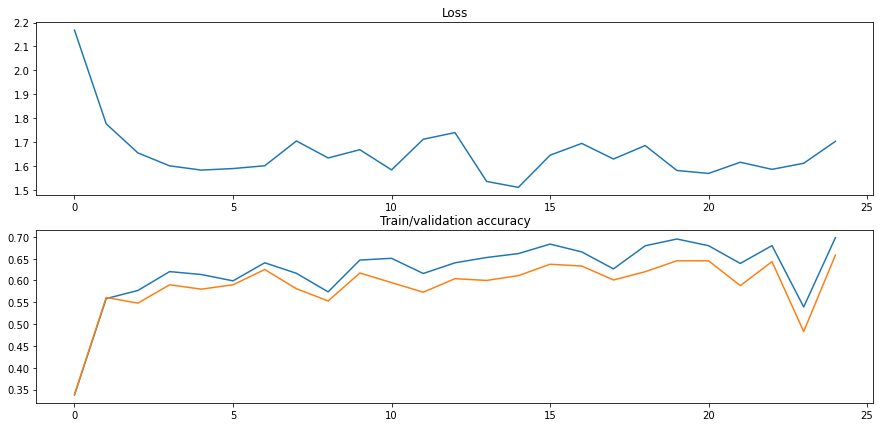

In [39]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [40]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.609000
